# K-Means Clustering of Retail Dataset

John Bonfardeci - 2020-03-22

We will use the unsupervised learning ML technique of K-Means clustering, where we seek to identity 3 primary groups of customers in the transnational retail dataset. In this case, our goal is to identify broad market segments when these segments are unknown. K-Means clustering groups together rows that are more mathematically similar using the Euclidian Distance formula. These clusters are assigned a numeric label and can also be used as a predictor in subsequent ML models. Therefore, K-Means also provides us a method for *feature engineering* where it's desirable to create more predictors to increase accuracy in models.

## Python Libraries we will use

In [ ]:
# Import libraries
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.decomposition import PCA
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
%matplotlib inline
import pandas as pd
import math
import seaborn as sns
from revoscalepy import rx_import

## Global Variables

In [2]:
# Change data_dir to folder on your computer.
data_dir = "data/"
filepath = data_dir+"OnlineRetail.xdf"

## Reusable Utility Functions

In [20]:
# Functions

def is_nan(df):
    """
    Handle NaN
    """
    def _nan(x):  
        for i in range(len(x)):
            if math.isnan(x[i]) or math.isinf(x[i]):
                x[i] = float(0.0)
        
        return x
        
    data = list(map(_nan, df.values))
    return pd.DataFrame(columns=df.columns, data=data)
    
def todict(row):
    """
    Convert data row to dictionary object.
    """
    d = {}
    cols = text_columns 
    for i in range(len(cols)):
        col = cols[i]
        d[col] = row[i]
        
    return d

def normalize(df):
    """
    Normalize and Scale the numerical columns
    """
    data = df.copy().values   
    min_max_scaler = preprocessing.MinMaxScaler()
    scaled_data = min_max_scaler.fit_transform(data)
    return pd.DataFrame(columns=df.columns, data=scaled_data)

def plot_scree(percent_variance):
    """
    Create Scree Plot of Principal Components Variance
    """  
    # Visualize the variance explained for each observation by the principal components
    cols = []
    for i in range(len(percent_variance)):
        cols.append('PC'+str(i+1))

    sns.barplot(y=cols, x=percent_variance)
    plt.title('PCA Scree Plot - larger explains more variance')
    plt.show()

## Import the Data
Peak at the first 5 rows.

In [89]:
# Import XDF Online Retail data set
df = rx_import(filepath)
df.head()

Rows Read: 397924, Total Rows Processed: 397924, Total Chunk Time: 1.164 seconds 


,InvoiceNo,StockCode,Description,Quantity,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,3.39,17850,United Kingdom


### Convert text values to numerical hashes.
Both PCA and K-Means work with numerical values only.

In [70]:
# Convert text values into number hashes and normalize numeric values.
df_hashed = df.copy().drop(['Description', 'Country', 'CustomerID', 'StockCode', 'InvoiceNo'], axis=1)

hasher = HashingVectorizer(n_features=2**6)

# Hash Descriptions
description_hash = hasher.transform(df['Description'].values).toarray()
df_desc = pd.DataFrame(columns=['desc'+str(n) for n in range(len(description_hash[0]))]
                         , data=description_hash)

# Hash Countries
country_hash = hasher.transform(df['Country'].values).toarray()
df_country = pd.DataFrame(columns=['country'+str(n) for n in range(len(country_hash[0]))]
                         , data=country_hash)

# Combine hashed dataframes
df_hashed = pd.concat([df_hashed, df_desc, df_country], axis=1)

# Add other columns
#df_hashed.set_index('InvoiceNo', inplace=True)
df_hashed = df_hashed.dropna()
df_hashed.describe()

,Quantity,UnitPrice,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,...,country54,country55,country56,country57,country58,country59,country60,country61,country62,country63
count,3.972130e+05,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,...,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000,397213.000000
mean,-1.248331e+07,3.391413,-0.004018,0.013961,-0.004501,-0.042124,-0.003797,0.007263,0.003709,0.003275,...,0.000003,-0.000347,0.004620,0.000028,-0.000038,-0.000010,-0.005846,-0.000028,0.000175,-0.002910
std,1.632543e+08,130.424492,0.090350,0.112350,0.102185,0.142524,0.105742,0.125711,0.100375,0.082257,...,0.010160,0.020685,0.068696,0.010644,0.008834,0.007096,0.077185,0.007933,0.020959,0.055207
min,-2.147484e+09,0.000000,-0.816497,-0.707107,-1.000000,-0.816497,-0.577350,-1.000000,-0.577350,-0.707107,...,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000
25%,2.000000e+00,1.250000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000e+00,1.950000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.200000e+01,3.750000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,7.421500e+04,80995.000000,0.707107,0.707107,0.816497,0.577350,1.000000,0.707107,0.816497,0.577350,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [78]:
# Normalize data
df_normal = normalize(df_hashed)
df_normal.head()

,Quantity,UnitPrice,desc0,desc1,desc2,desc3,desc4,desc5,desc6,desc7,...,country54,country55,country56,country57,country58,country59,country60,country61,country62,country63
0,0.999965,0.000031,0.535898,0.5,0.550510,0.585786,0.366025,0.585786,0.414214,0.55051,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
1,0.999965,0.000042,0.535898,0.5,0.550510,0.585786,0.366025,0.585786,0.414214,0.55051,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
2,0.999965,0.000034,0.535898,0.5,0.796706,0.585786,0.366025,0.585786,0.414214,0.55051,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
3,0.999965,0.000042,0.535898,0.5,0.550510,0.585786,0.366025,0.585786,0.414214,0.55051,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5
4,0.999965,0.000042,0.535898,0.5,0.550510,0.264938,0.366025,0.585786,0.414214,0.55051,...,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5,0.5


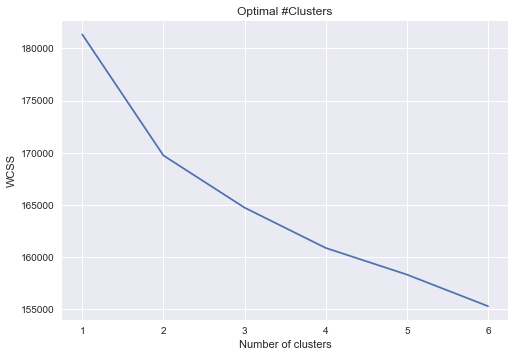

In [97]:
# Use visual diagnostic to estimate optimal number of clusters
cluster_range = range(1, 7)
wcss = []
for i in cluster_range:
    kmeans = KMeans(n_clusters=i, n_jobs=4, algorithm='full', random_state=123)
    kmeans.fit(df_normal)
    wcss.append(kmeans.inertia_)
    
plt.plot(cluster_range, wcss)
plt.title('Optimal #Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

## K-Means
https://scikit-learn.org/stable/modules/clustering.html#k-means
K-means is often referred to as Lloyd’s algorithm. In basic terms, the algorithm has three steps. The first step chooses the initial centroids, with the most basic method being to choose  samples from the dataset . After initialization, K-means consists of looping between the two other steps. The first step assigns each sample to its nearest centroid. The second step creates new centroids by taking the mean value of all of the samples assigned to each previous centroid. The difference between the old and the new centroids are computed and the algorithm repeats these last two steps until this value is less than a threshold. In other words, it repeats until the centroids do not move significantly.

In [93]:
km = KMeans(n_clusters=4, 
            random_state=123, 
            verbose=True, 
            n_jobs=4, 
            algorithm='full')

kmeans_data = km.fit_transform(df_normal)
clusters = km.predict(df_normal)
labels = km.labels

In [94]:
# Create dataframe for our PC variables.
k_columns = []
for i in range(len(kmeans_data[0])):
    k_columns.append('PC'+str(i+1))
    
kmeans_df = pd.DataFrame(columns=k_columns, data=kmeans_data)
kmeans_df.head()

,PC1,PC2,PC3,PC4
0,0.827209,0.753764,0.664877,0.587469
1,0.768655,0.628596,0.606339,0.535899
2,0.801518,0.664319,0.571664,0.613811
3,0.846395,0.719871,0.715896,0.637112
4,0.825899,0.765297,0.597899,0.618859


C:\Program Files\Microsoft\PyForMLS\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:724: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if zdir == 'x':
C:\Program Files\Microsoft\PyForMLS\lib\site-packages\mpl_toolkits\mplot3d\art3d.py:726: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif zdir == 'y':


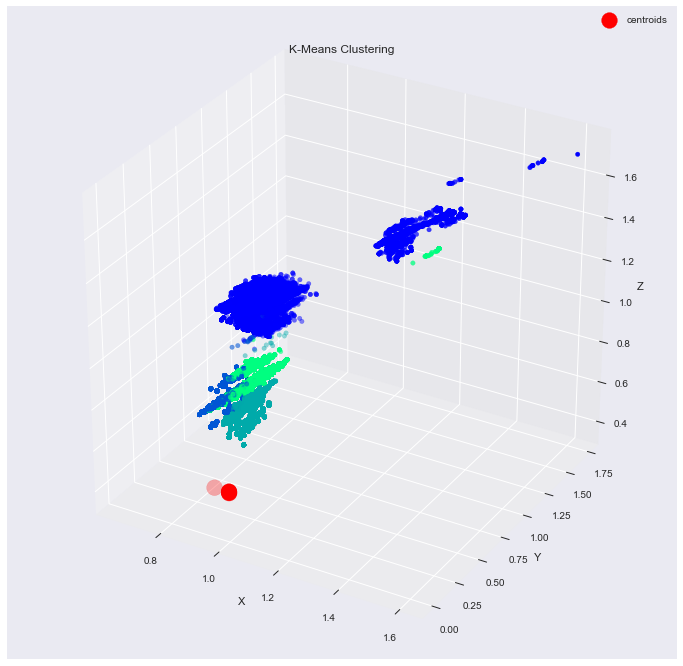

In [96]:
#Plot the clusters obtained using k means
# https://thatascience.com/learn-machine-learning/kmeans/
fig = plt.figure(1, figsize=(12, 12))
ax = fig.add_subplot(111, projection='3d')

# Plot Cluster Centroids
scatter = ax.scatter(km.cluster_centers_[:, 0], # get 1st N of each row
                     km.cluster_centers_[:, 1], # get 2nd N of each row
                     km.cluster_centers_[:, 2], # get 3rd N of each row
                     km.cluster_centers_[:, 3], # get 3rd N of each row
                     s = 250, 
                     marker='o', 
                     c='red', 
                     label='centroids')

# Plot Cluster X, Y, Z points
scatter = ax.scatter(kmeans_data[:, 0], 
                     kmeans_data[:, 1], 
                     kmeans_data[:, 2],
                     kmeans_data[:, 3],
                     c=clusters, 
                     s=20, 
                     cmap='winter')

ax.set_title('K-Means Clustering')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.legend()
plt.show()

In [91]:
# Export Scored Model to CSV
kmeans_df['Labels'] = km.labels_
kmeans_df.head()

In [92]:
kmeans_df.to_csv(data_dir+'OnlineRetailScored.csv')

,PC1,PC2,PC3,PC4,Labels
0,0.827209,0.753764,0.664877,0.587469,3
1,0.768655,0.628596,0.606339,0.535899,3
2,0.801518,0.664319,0.571664,0.613811,2
3,0.846395,0.719871,0.715896,0.637112,3
4,0.825899,0.765297,0.597899,0.618859,2
